## Project Group - 31

Members (student number): 
- Gijs de Werd          (4717775)
- Georges Puttaert      (4686160)
- Thijs Roolvink        (4961382)
- Jim van Oosten        (4734998)

A link to the Github Repository: https://github.com/jimvanoosten/TIL6022_Group31

### Research Objective

**Main question**: 

'How does the correlation between air passenger volume, GDP, and tourism numbers influence the clustering of EU countries between 2010 and 2020?'

**Hypotheses**: 

- High air passenger volume and tourism are positively correlated with GDP, leading to identifiable clusters among EU countries.
- Conversely, low-GDP countries are expected to show weaker correlations with tourism, resulting in a lack of distinct clustering.

**Sub questions**:

1. 'What insights into economic resilience for EU countries from 2010 to 2020 can be derived from analyzing air passenger volume, GDP, and tourism data?'

2. 'Are patterns evident in the time series data of air passenger volume, GDP, and tourism numbers across countries from 2010 to 2020?'

3. 'How do the three key metrics — air passenger volume, GDP, and tourism numbers — correlate with each other across countries?

4. 'How do countries cluster together when analyzed based on air passenger volume, GDP, and tourism data?'

5. 'What common aspects can be identified within these clusters that hint at their economic resilience?'

6. 'How do member countries' key metrics distribute in the identified clusters?'

## Data Used

1: Eurostat. (2023). GDP and main components (output, expenditure and income). European Commission. https://ec.europa.eu/eurostat/databrowser/view/namq_10_gdp/default/table?lang=en \
2: Eurostat. (2023). GDP and main components (output, expenditure and income). European Commission. https://ec.europa.eu/eurostat/databrowser/view/namq_10_gdp/default/table?lang=en \
3: Eurostat. (2023). Nights spent at tourist accommodation establishments. European Commission. https://ec.europa.eu/eurostat/databrowser/product/view/tour_occ_nim \
4: wbdata contributors. (2023). wbdata: A Python package to interact with the World Bank's datasets. Read the Docs. https://wbdata.readthedocs.io/en/latest/index.html

## 2. Data preperation

This chapter contains the preparation of the data. Making ready dataframes for air passengers, tourism and GDP data. Additionaly, merging the data together. Also, packages are imported and libraries are imported.

In [1]:
#Uncomment the following line if installing packages is needed

# pip install pandas matplotlib scikit-learn scipy numpy seaborn plotly country-converter wbdata

In [2]:
#import packages and libraries

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
import scipy.stats as stats
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import dendrogram, linkage
import country_converter as coco
import plotly.express as px
import wbdata
import plotly.figure_factory as ff
from ipywidgets import interact, Output

In [3]:
#Importing the datasets from Ec.Europa
traffic = pd.read_csv('Datasets/air_passengers_from2000.csv')
tourism = pd.read_csv('Datasets/tourism_from2000.csv')
gdp = pd.read_csv('Datasets/gdp_from2000.csv')

In [4]:
# Define a function to convert quarterly periods to monthly periods
def quarter_to_month(quarter):
    """ Check which quarter it is and return the corresponding three months in YYYY-MM format """
    year, qtr = quarter.split('-')
    if qtr == 'Q1':
        return [f'{year}-01', f'{year}-02', f'{year}-03']
    elif qtr == 'Q2':
        return [f'{year}-04', f'{year}-05', f'{year}-06']
    elif qtr == 'Q3':
        return [f'{year}-07', f'{year}-08', f'{year}-09']
    else: # 'Q4'
        return [f'{year}-10', f'{year}-11', f'{year}-12']

#Updating the gdp dataframe
mask = gdp['TIME_PERIOD'].str.match(r'\d{4}-Q[1-4]$')
gdp.loc[mask, 'TIME_PERIOD'] = gdp.loc[mask, 'TIME_PERIOD'].apply(quarter_to_month)
gdp = gdp.explode('TIME_PERIOD')

In [5]:
#Data Cleaning

#Renaming the columns from OBS_VALUE to the factor
traffic = traffic.rename(columns={'OBS_VALUE': 'Traffic'})
tourism = tourism.rename(columns={'OBS_VALUE': 'Tourism'})
gdp = gdp.rename(columns={'OBS_VALUE': 'GDP'})

# Filtering the time period from 01-2010 until 01-2020 for each factor dataframe
traffic_filtered = traffic[
    (traffic['tra_meas'] == 'PAS_BRD') &
    (traffic['TIME_PERIOD'] >= '2010-01') & 
    (traffic['TIME_PERIOD'] <= '2020-01')                   
]

tourism_filtered = tourism[
    (tourism['unit'] == 'NR') &
    (tourism['nace_r2'] == 'I551') &
    (tourism['c_resid'] == 'TOTAL') &
    (tourism['TIME_PERIOD'] >= '2010-01') &
    (tourism['TIME_PERIOD'] <= '2020-01')
]

gdp_filtered = gdp[
    (gdp['unit'] == 'CP_EUR_HAB') &
    (gdp['s_adj'] == 'NSA') &
    (gdp['na_item'] == 'B1GQ') &
    (gdp['TIME_PERIOD'] >= '2010-01') &
    (gdp['TIME_PERIOD'] <= '2020-01')
]

In [6]:
# Merging the 3 factor dataframes to one merged dataframe called
countries = ["AT", "BE", "BG", "CY", "CZ", "DE", "DK", "EE", "EL", "ES", "FI", "FR", "HR", "HU", 'UK', "IT", "LT", "LU", "LV", "MT", "NL", "PL", "PT", "RO", "SE", "SI", "SK"]

traffic_filtered = traffic_filtered[traffic_filtered['geo'].isin(countries)]
tourism_filtered = tourism_filtered[tourism_filtered['geo'].isin(countries)]
gdp_filtered = gdp_filtered[gdp_filtered['geo'].isin(countries)]


merged_data = pd.merge(traffic_filtered[['TIME_PERIOD', 'geo', 'Traffic']], 
                       gdp_filtered[['TIME_PERIOD', 'geo', 'GDP']], 
                       on=['TIME_PERIOD', 'geo'], 
                       how='outer')

merged_data = pd.merge(merged_data,
                       tourism_filtered[['TIME_PERIOD', 'geo', 'Tourism']], 
                       on=['TIME_PERIOD', 'geo'], 
                       how='outer')

In [7]:
# Prepare data for usage of the World Bank data package
# Creating a Dataframe with the right coutry codes and names
countries_df = pd.DataFrame()
countries_df['country'] = countries
cc = coco.CountryConverter()
countries_df['country'] = countries_df['country'].replace('EL', 'GR')  # Greece has the wrong code for the wb library
countries_df['country'] = cc.pandas_convert(series=countries_df['country'], to='ISO3')
countries_df['country names'] = cc.convert(names=countries_df['country'], to="name")

## 3. Visualization General Plots

### Difference in GNI within the EU countries
Below, the GNI (Gross National Income) per capita for all Europian Union countries for the years 2010 and 2020 are given. This data is published by the worldbank, World development indicators database. This bar plot gives a first impressions on the GNI differnces between European countries and visualizes the European average. 

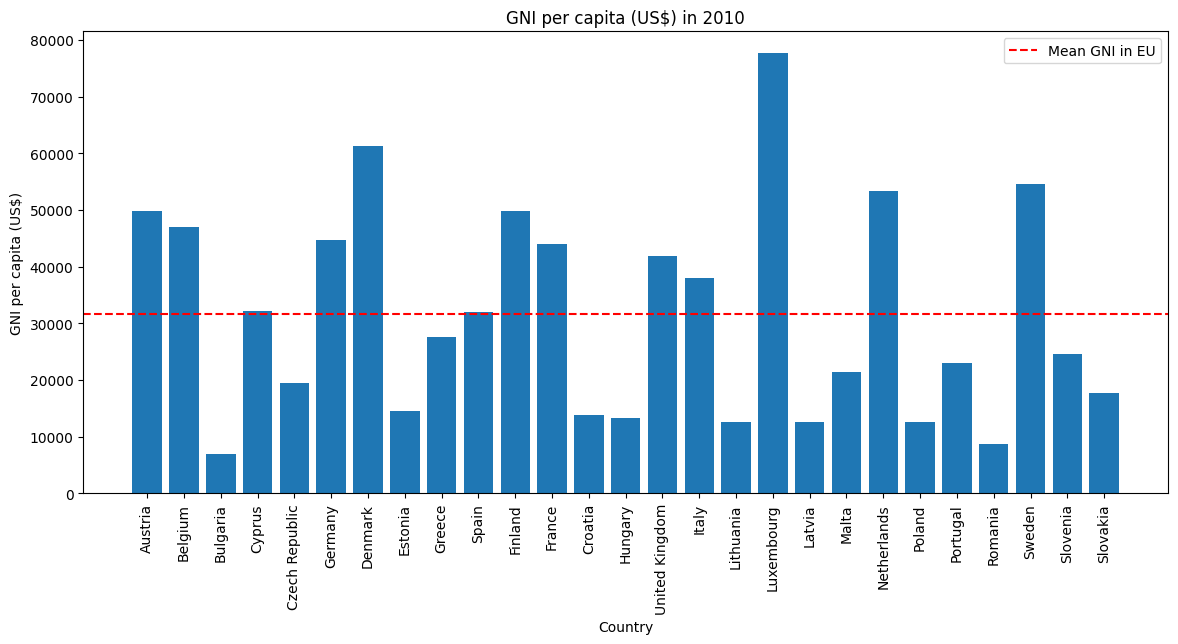

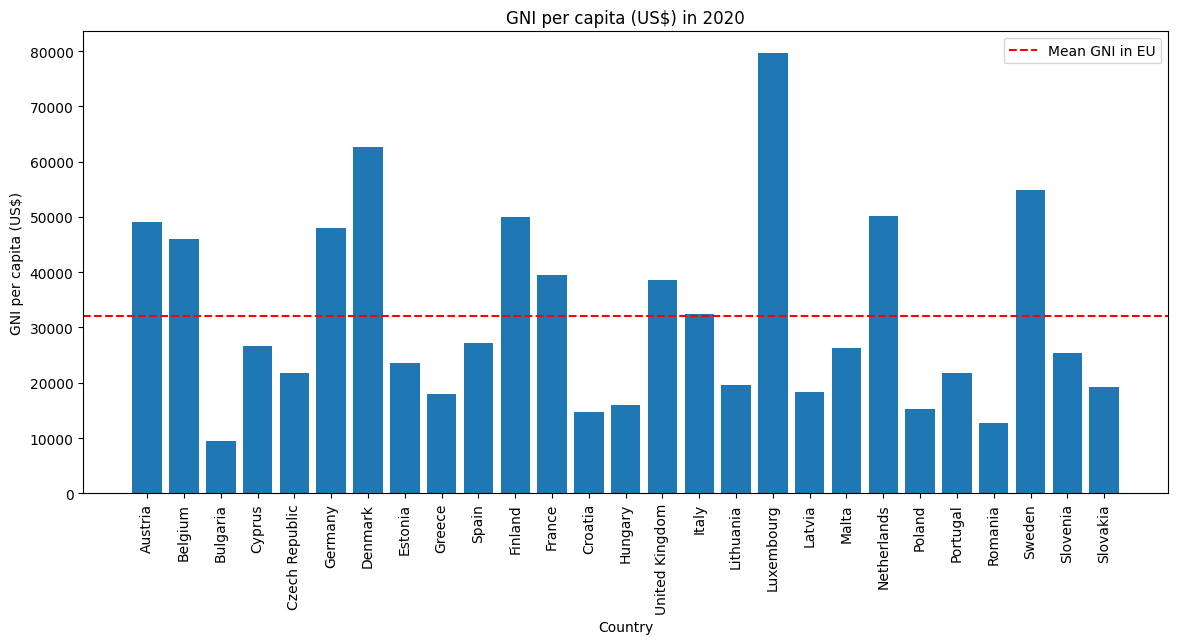

In [8]:
# Define the economic indicator, its corresponding code and the years to plot
indicator = "GNI per capita (US$)"
indicator_code = {'NY.GNP.PCAP.CD': 'GNI per capita (US$)'}
years = ['2010', '2020']

# Initialize the DataFrame to store the data
for year in years:
    countries_df[year] = 0

# Loop through each country and year to fetch GNI per capita data
for i in range(len(countries_df)):
    for j in years:
        data = wbdata.get_dataframe(indicator_code, country=countries_df['country'][i])
        value = data[f'{indicator}'][f'{j}']
        countries_df.loc[i, f'{j}'] = value

# Create bar plots for each year
for year in years:
    plt.figure(figsize=(14, 6))
    plt.bar(countries_df['country names'], countries_df[year])
    plt.axhline(countries_df[f'{year}'].mean(), color='red', linestyle='--', label='Mean GNI in EU')
    plt.xlabel('Country')
    plt.ylabel(f'{indicator}')
    plt.title(f'{indicator} in {year}')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

### Time series interactive plot

Below, a interactive plot can be found for all European countries. It contains the three aspects, the default option is 'no country'. Data can be visualized by clicking on countries and or aspects on the right side.

In [9]:
merged_data = merged_data.sort_values(by=['geo', 'TIME_PERIOD'])

fig = go.Figure()

# Scatter for Traffic
for country in merged_data['geo'].unique():
    country_data = merged_data[merged_data['geo'] == country]
    fig.add_trace(go.Scatter(
        x=country_data['TIME_PERIOD'],
        y=country_data['Traffic'],
        mode='lines',
        name=f"Traffic {country}",
        visible="legendonly"
    ))

# Scatter forTourism
for country in merged_data['geo'].unique():
    country_data = merged_data[merged_data['geo'] == country]
    fig.add_trace(go.Scatter(
        x=country_data['TIME_PERIOD'],
        y=country_data['Tourism'],
        mode='lines',
        name=f"Tourism {country}",
        visible="legendonly"
    ))

# Scatter for GDP
for country in merged_data['geo'].unique():
    country_data = merged_data[merged_data['geo'] == country]
    fig.add_trace(go.Scatter(
        x=country_data['TIME_PERIOD'],
        y=country_data['GDP'],
        mode='lines',
        name=f"GDP {country}",
        yaxis="y2",  
        visible="legendonly"
    ))

fig.update_layout(
    title='Traffic, Tourism, and GDP (2010-2022)',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Traffic/Tourism Value'),
    yaxis2=dict(title='GDP Value', overlaying='y', side='right', title_standoff=25), 
    showlegend=True,
    legend=dict(x=1.05)
)

fig.show()


### Correlation heatmap

In [10]:
def generate_correlation_heatmap(country):
    country_data = merged_data[merged_data['geo'] == country]
    correlation_matrix = country_data[['Traffic', 'GDP', 'Tourism']].corr()
    
    heatmap = go.Figure(data=go.Heatmap(
        z=correlation_matrix.values,
        x=correlation_matrix.columns,
        y=correlation_matrix.index,
        colorscale=px.colors.sequential.Emrld))

    heatmap.update_layout(title=f'Correlation Heatmap for {country}')
    return heatmap

output = Output()

@interact(country=countries)
def interactive_heatmap(country):
    with output:
        heatmap = generate_correlation_heatmap(country)
        heatmap.show()

interactive(children=(Dropdown(description='country', options=('AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE',…

## 4. Unsupervised learning: Kmeans clustering

In [11]:
# Scaling the data with the standardscalar 
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_data[['Traffic','Tourism', 'GDP']])

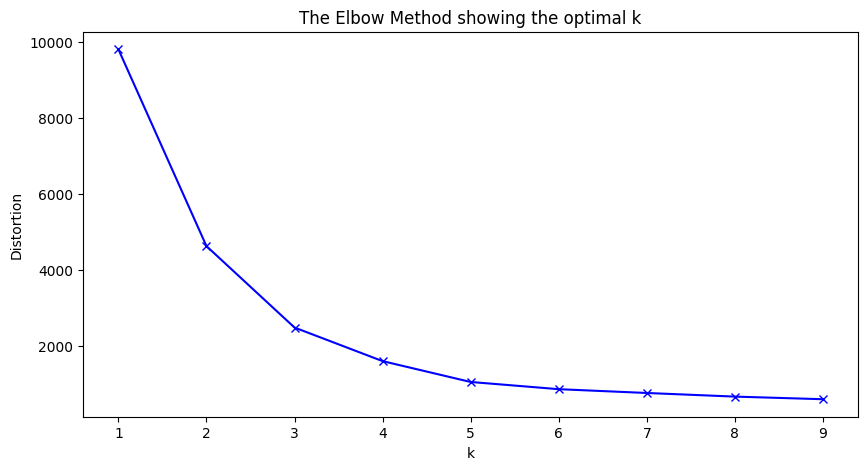

In [12]:
# Determine the number of clusters
distortions = []
# Give a range of 10 K's to determine the optimal K
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init = 10)
    kmeanModel.fit(scaled_data)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [13]:
# The K of three is filled in the Kmeans is done
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
clusters = kmeans.fit_predict(scaled_data)
merged_data['Cluster'] = clusters

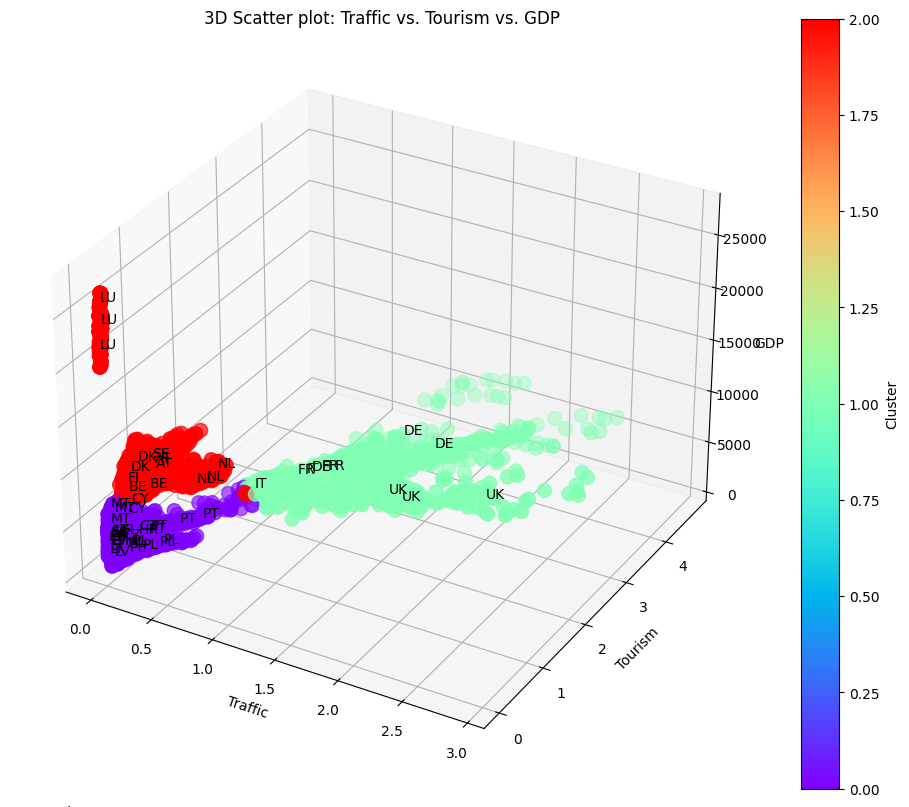

In [14]:
# 3D scatter plot of the three aspects
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot is made
sc = ax.scatter(merged_data['Traffic'], merged_data['Tourism'], merged_data['GDP'], c=merged_data['Cluster'], cmap='rainbow', s=100)

# Anootating 2% of all datpoints to make the scatter plot more clear
for i, row in merged_data.iterrows():
    if np.random.rand() < 0.02:
        ax.text(row['Traffic'], row['Tourism'], row['GDP'], row['geo'])

# Labeling the axis and title
ax.set_xlabel('Traffic')
ax.set_ylabel('Tourism')
ax.set_zlabel('GDP')
ax.set_title('3D Scatter plot: Traffic vs. Tourism vs. GDP')

fig.colorbar(sc).set_label('Cluster')

plt.show()

In [15]:
def mode_cluster(x):
    """ In this function the most frequent value of the datapoints is returned to get the overall cluster"""
    mode, _ = stats.mode(x, keepdims= True)

    return mode[0]

# This finds the cluster for each country and resets the index to create a new DataFrame with cluster as key and countries as value
country_clusters = merged_data.groupby('geo')['Cluster'].apply(mode_cluster).reset_index()
cluster = {}
for cluster_num in range(k):
    print(f"Cluster {cluster_num}: {', '.join(country_clusters[country_clusters['Cluster'] == cluster_num]['geo'].tolist())}")
    # Store the countries belonging to this cluster in the 'cluster' dictionary
    cluster[cluster_num] = country_clusters[country_clusters['Cluster'] == cluster_num]['geo'].tolist()

Cluster 0: BG, CY, CZ, EE, EL, HR, HU, LT, LV, MT, PL, PT, RO, SI, SK
Cluster 1: DE, ES, FR, IT, UK
Cluster 2: AT, BE, DK, FI, LU, NL, SE


### Boxplot per cluster 

Below are the boxplots for each aspects containing the three cluster. There can be seen how the aspect per cluster is distributed. As the hypotheses at the beginning, there can be indeed seen that some of them are true, for example the cluster in which the air passengers and tourism are very high. Or the cluster in which the air passengers and tourism are relatively low but with a high GDP. These are countries not that determined by tourism. 

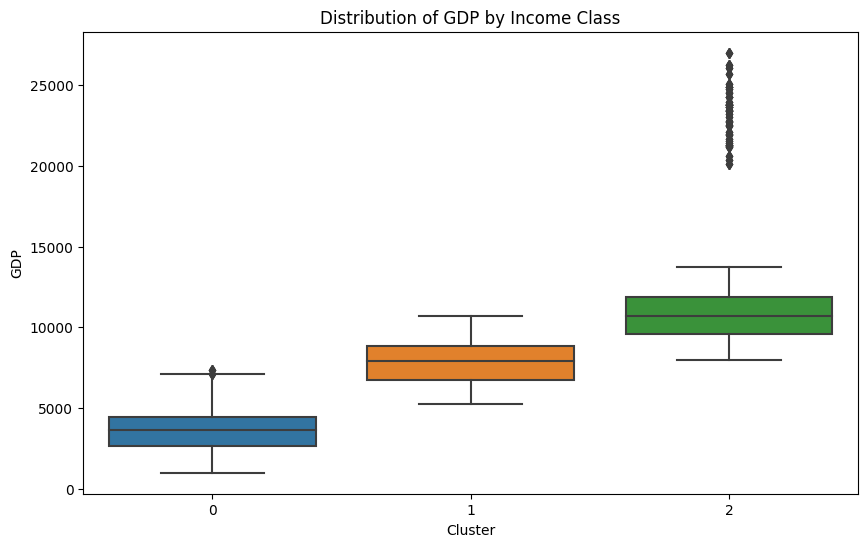

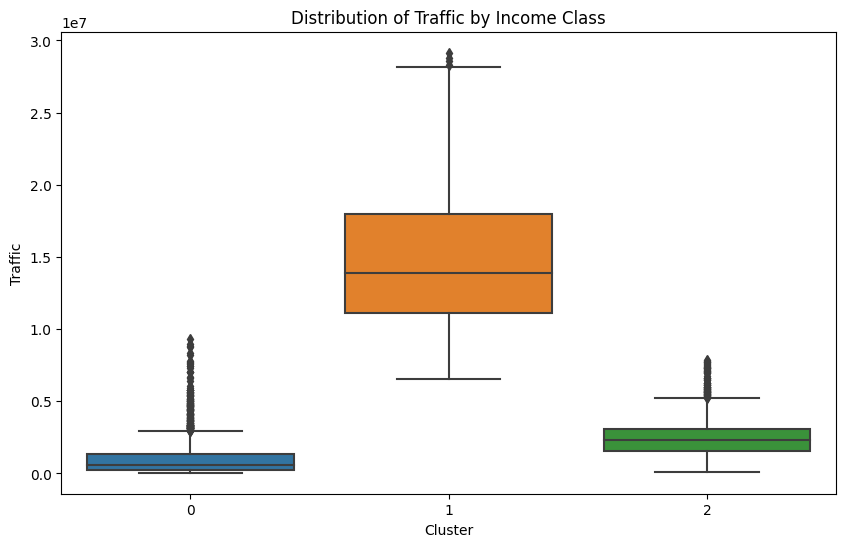

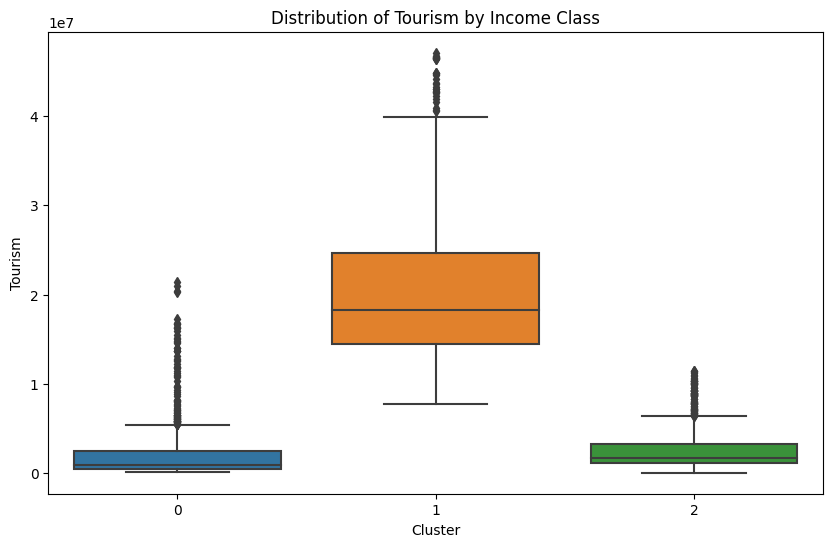

In [16]:
# This dict maps each country to its respective cluster based on the 'cluster' dictionary
country_to_cluster = {country: cluster for cluster, countries in cluster.items() for country in countries}
merged_data['Income Class'] = merged_data['geo'].map(country_to_cluster)
metrics = ['GDP', 'Traffic', 'Tourism']

for metric in metrics:
    plt.figure(figsize=(10, 6))
    # Create a boxplot where 'Income Class' is on the x-axis and the selected metric is on the y-axis
    sns.boxplot(x='Income Class', y=metric, data=merged_data)
    plt.title(f'Distribution of {metric} by Income Class')
    plt.ylabel(metric)
    plt.xlabel('Cluster')
    plt.show()

### Hierachical Clustering

A Hierachical Clustering is used to visualize the dendrogram of each cluster for each factor (Traffic, Tourism and GDP). The dendogram reveals the similarity in terms of the factors. The 'Distance' in the X-axis can be interpreted as a measure of dissimilarity. The lower the distance at which two countries merge in the dendrogram, the more similar they are.

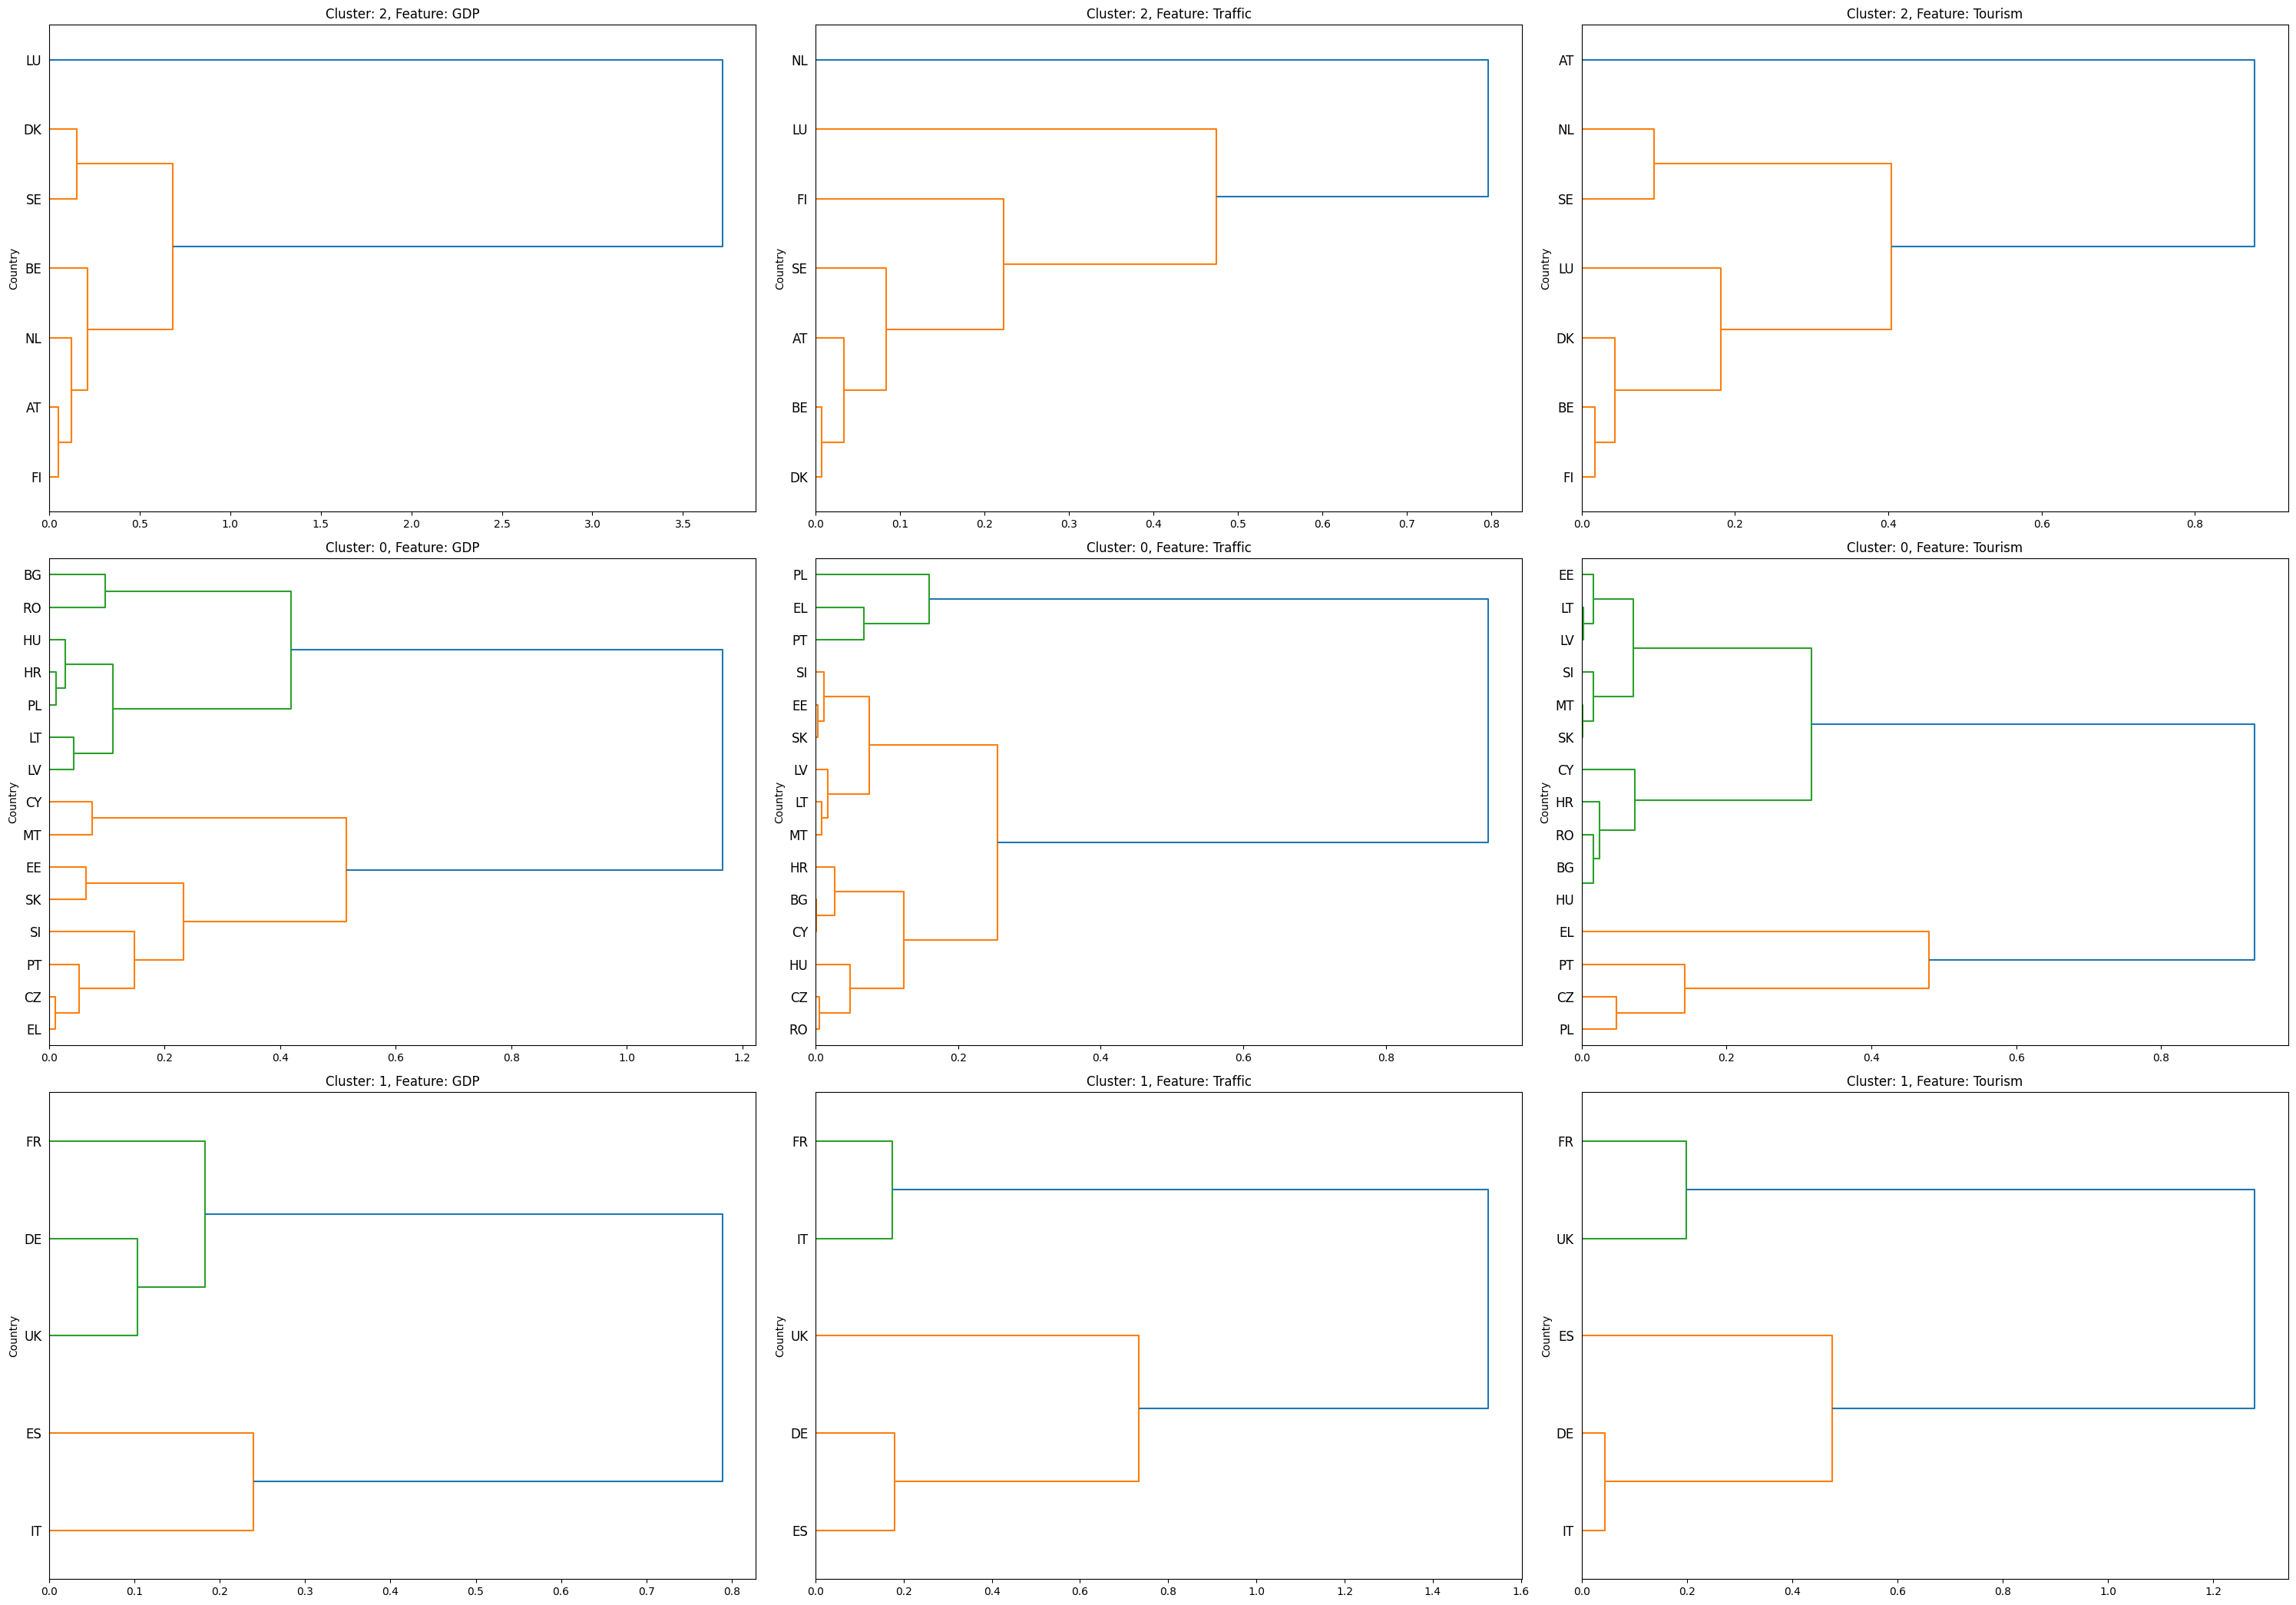

In [17]:
scaler = StandardScaler()
scale_cols = ['GDP','Traffic', 'Tourism']

merged_data_scaled = merged_data.copy()
merged_data_scaled[scale_cols] = scaler.fit_transform(merged_data_scaled[scale_cols])

# Create a set of unique income classes
income_clusters = merged_data_scaled['Income Class'].unique()

plt.figure(figsize=(30, 7 * len(income_clusters)))
for i, cluster in enumerate(income_clusters):
    sub_df = merged_data_scaled[merged_data_scaled['Income Class'] == cluster]
    mean_sub_df = sub_df.groupby('geo')[scale_cols].mean()
    for j, col in enumerate(scale_cols):
        plt.subplot(len(income_clusters), len(scale_cols), i * len(scale_cols) + j + 1)
        # Perform hierarchical clustering
        linked = linkage(mean_sub_df[[col]], method='ward')
        
        # Plot the dendrogram
        plt.title(f'Cluster: {cluster}, Feature: {col}')
        dendrogram(linked, orientation='right', distance_sort='descending', labels=mean_sub_df.index)
        plt.ylabel('Country')
        
plt.tight_layout()
plt.show()

### Europe country map

In [18]:
cc = coco.CountryConverter()
# Replace the value 'EL' with 'GR' in the 'geo' column of the 'merged_data' DataFrame
merged_data['geo'] = merged_data['geo'].replace('EL', 'GR')
# Use the CountryConverter to convert the values in the 'geo' column to ISO3 country codes
iso3_codes = cc.pandas_convert(series=merged_data['geo'], to='ISO3')
#Add teh ISO3 codes of country is to the column 'geo_ISO_3'
merged_data['geo_ISO_3'] = iso3_codes

In [19]:
# Iterate over clusters in the 'income_clusters' list along with their index (i)
for i, cluster in enumerate(income_clusters):
    sub_df = merged_data[merged_data['Income Class'] == cluster]
    for j, col in enumerate(scale_cols):
        # Create a choropleth map
        fig = px.choropleth(
            sub_df,
            locations='geo_ISO_3',
            locationmode='ISO-3',
            color=col,
            hover_name='geo',
            animation_frame='TIME_PERIOD',
            title= str(col) + ' of European Countries of Cluster ' + str(cluster) + ' from 2010 to 2020',
            scope='europe',
            color_continuous_scale=px.colors.sequential.Emrld,
            range_color = (min(sub_df[col]), max(sub_df[col])),
            height = 1000, 
            width = 750
        )

        # Adjust the slider properties
        sliders_dict = {
            'active': 0,
            'yanchor': 'top',
            'xanchor': 'left',
            'currentvalue': {
                'font': {'size': 15},
                'prefix': 'Year:',
                'visible': True,
                'xanchor': 'right'
            }
        }
        # Update layout to include the slider and map appearance
        fig.update_layout(sliders=[sliders_dict])
        fig.update_layout(geo=dict(showframe=False, showcoastlines=False))
        fig.update_geos(fitbounds="locations")
        fig.show()

## 5. Dashboard made with Dash 

http://127.0.0.1:8051/